<a href="https://colab.research.google.com/github/Ishan-Bhattacharya/House_prediction_with_explainability/blob/main/Explainable_house_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Prediction with Explainable AI

This project aims to predict house prices using a neural network enhanced with city embeddings, while ensuring model interpretability through SHAP (SHapley Additive exPlanations). The goal is to build a robust predictive model and understand which features most influence price predictions, making it valuable for real estate analytics or data science applications. The notebook also includes a baseline linear regression model for comparison.

In [11]:
#run this the firsrt time you run this notebook and then restart kernel

!pip install --upgrade pandas==2.0.3 numpy==1.25.2

  Using cached pandas-2.0.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached pandas-2.0.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dice-ml 0.11 requires pandas<2.0.0, but you have pandas 2.0.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.0.3 which is incompatible.
xarray 2025.1.2 requires pandas>=2.1, but you have pandas 2.0.3 which is incompatible.
mizani 0.13.2 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.


"The dataset is sourced from Kaggle ([House Data by shree1992](https://www.kaggle.com/shree1992/housedata)), containing approximately 4,600 records of house sales in the King County area. Key features include `sqft_living` (living space square footage), `city`, `bedrooms`, `bathrooms`, `yr_built`, and `price` (the target variable). The data is preprocessed to handle categorical variables (e.g., `city`) and engineer new features like `Age` (current year minus `yr_built`) and `Renovated` (binary indicator for renovations)."

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.


# --------------------------------------------
# 1. IMPORTING IMPORTANT MODULES AND DATASET
# --------------------------------------------
!pip install shap

import dice_ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import shap


#importing the data

import kagglehub
shree1992_housedata_path = kagglehub.dataset_download('shree1992/housedata')

print('Data source import complete.')

import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

data = pd.read_csv('/kaggle/input/housedata/data.csv')

  Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
xarray 2025.1.2 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.2 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
dask-

# 2. Preprocessing

Data preparation involves several steps to ensure compatibility with the neural network:,
- **Shuffling and Splitting**: The dataset is shuffled and split into 80% training and 20% test sets for robust evaluation.,
- **Encoding**: The `city` feature is encoded using `LabelEncoder` to convert it into numerical values suitable for embedding,
- **Feature Engineering**: `Age` is calculated as 2025 minus `yr_built`, and `Renovated` is a binary flag (1 if `yr_renovated` > 0, 0 otherwise).,
- **Column Removal**: Irrelevant features (`date`, `street`, `statezip`, `country`) are dropped to reduce noise.,
This preprocessing ensures the data is clean and structured for modeling.

In [28]:
#2. PREPROCESSING 1

X = data.drop('price', axis = 1)
y = data['price']

X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

X_train = X_shuffled.iloc[: int(0.8 * len(data))]
X_test = X_shuffled.iloc[int(0.8 * len(data)):]
y_train = y_shuffled.iloc[:int(0.8 * len(data))]
y_test = y_shuffled.iloc[int(0.8 * len(data)):]


encoder = LabelEncoder()

X_train.loc[:, 'city'] = encoder.fit_transform(X_train['city'])
X_test.loc[:, 'city'] = encoder.transform(X_test['city'])

X_train['Age'] = 2025 - X_train['yr_built']
X_test['Age'] = 2025 - X_test['yr_built']

X_train = X_train.drop(['yr_built'], axis = 1)
X_test = X_test.drop(['yr_built'], axis = 1)

X_train['Renovated'] = np.where(X_train['yr_renovated'] == 0, 0, 1)
X_test['Renovated'] = np.where(X_test['yr_renovated'] == 0, 0, 1)

X_train = X_train.drop(['yr_renovated'], axis = 1)
X_test = X_test.drop(['yr_renovated'], axis = 1)

X_train = X_train.drop(['date','street','statezip', 'country'], axis = 1)
X_test = X_test.drop(['date','street','statezip', 'country'], axis = 1)

<ipython-input-28-0ac413efc7eb>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, 'city'] = encoder.fit_transform(X_train['city'])
<ipython-input-28-0ac413efc7eb>:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.loc[:, 'city'] = encoder.fit_transform(X_train['city'])
<ipython-input-28-0ac413efc7eb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [29]:
#4. EMBEDDING LAYER
city = data['city'].nunique()

city_input = Input(shape=(1,), name='city_input')
city_embeds = Embedding(input_dim = city, output_dim = 8)(city_input)
city_flat = Flatten()(city_embeds)

In [30]:
#5. PREPROCESSING 2

X_train_city = X_train['city']
X_train_num = X_train.drop(['city'], axis = 1)

X_train_num_variance = X_train_num.var()
low_variance_cols = X_train_num_variance[X_train_num_variance < 1e-6].index
X_train_num = X_train_num.drop(columns=low_variance_cols)

# 3. Modeling
"he predictive model is a neural network designed to handle both categorical and numerical features:
- **City Embedding**: The `city` feature is embedded into an 8-dimensional space using an `Embedding` layer, capturing geographic patterns.
- **Numerical Input**: Other features (e.g., `sqft_living`, `Age`) are fed through a dense layer.
- **Architecture**: The model concatenates these inputs, processes them through a dense layer (128 units with ReLU activation), and outputs a price prediction.
- **Baseline**: A linear regression model serves as a benchmark to compare the neural network’s performance.
The neural network is trained to minimize mean squared error, with ongoing efforts to evaluate its accuracy against the baseline.

In [54]:
#6. MODEL CREATION

num_shape = X_train_num.shape[1]
num_input = Input(shape=(num_shape,), name='numeric_input')
combo = tf.keras.layers.Concatenate()([city_flat,num_input])
layer1 = Dense(2, activation = 'relu')(combo)
# layer2 = Dense(2, activation = 'relu')(layer1)

# Main output for prediction
output1 = Dense(1, name='main_output')(layer1)

# Auxiliary output for SHAP (can be the same as the main output)
output2 = Dense(1, name='aux_output')(layer1)


model = Model(inputs = [city_input, num_input], outputs = [output1, output2])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ city_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 8)      │        352 │ city_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 20)        │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ numeric_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 2)         │         42 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ main_output (Dense) │ (None, 1)         │          3 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_output (Dense)  │ (None, 1)         │          3 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 400 (1.56 KB)

 Trainable params: 400 (1.56 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
#7. MODEL TRAINING

for col in X_train_num.columns:
    if X_train_num[col].dtype == 'object':
        try:
            X_train_num[col] = pd.to_numeric(X_train_num[col])
        except ValueError:
            # Handle columns that cannot be directly converted
            # You may need to encode categorical columns
            print(f"Column '{col}' could not be converted to numeric. Consider using appropriate encoding.")

# Fit the model after the data type conversion
history = model.fit([X_train_city, X_train_num], [y_train,y_train], epochs=75, batch_size=16, verbose=1)

Epoch 1/75
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - aux_output_loss: 662314090496.0000 - loss: 1325075267584.0000 - main_output_loss: 662761308160.0000
Epoch 2/75
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - aux_output_loss: 525941538816.0000 - loss: 1053115219968.0000 - main_output_loss: 527173779456.0000
Epoch 3/75
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - aux_output_loss: 620841992192.0000 - loss: 1243563950080.0000 - main_output_loss: 622721892352.0000
Epoch 4/75
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - aux_output_loss: 451877208064.0000 - loss: 905996664832.0000 - main_output_loss: 454119555072.0000
Epoch 5/75
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - aux_output_loss: 629308063744.0000 - loss: 1261083557888.0000 - main_output_loss: 631775494144.0000
Epoch 6/75
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - aux_output_loss: 380158443520.0000 - loss: 762812497920.0000 - main_output_loss: 382654054400.0000
Epoch 7/75
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - aux_output_loss: 5329331

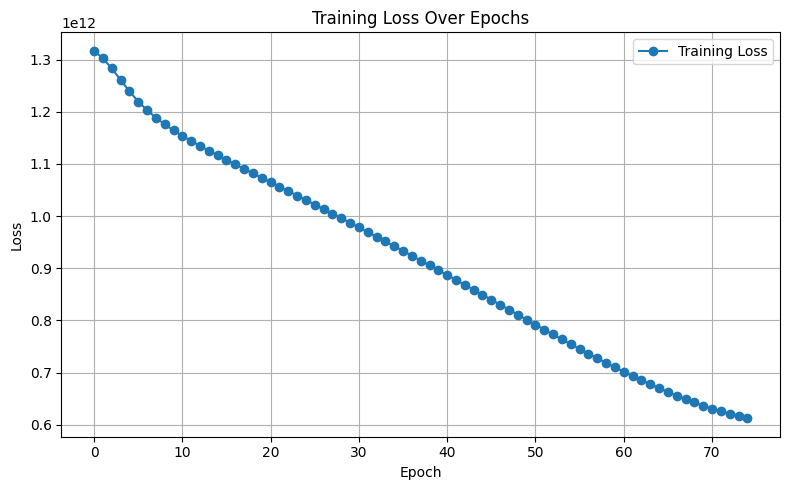

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
#8. EVALUATION AND TESTING

X_test_city = X_test['city']
X_test_num = X_test.drop(['city'], axis = 1)

X_test_num = X_test_num.drop(columns=low_variance_cols)

for col in X_test_num.columns:
    if X_test_num[col].dtype == 'object':
        try:
            X_test_num[col] = pd.to_numeric(X_test_num[col])
        except ValueError:
            print(f"Column '{col}' could not be converted to numeric. Consider using appropriate encoding")


evals = model.evaluate([X_test_city,X_test_num], [y_test, y_test])

evals

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - aux_output_loss: 101684461568.0000 - loss: 203472011264.0000 - main_output_loss: 101715812352.0000


[178271993856.0, 88610725888.0, 88585265152.0]

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


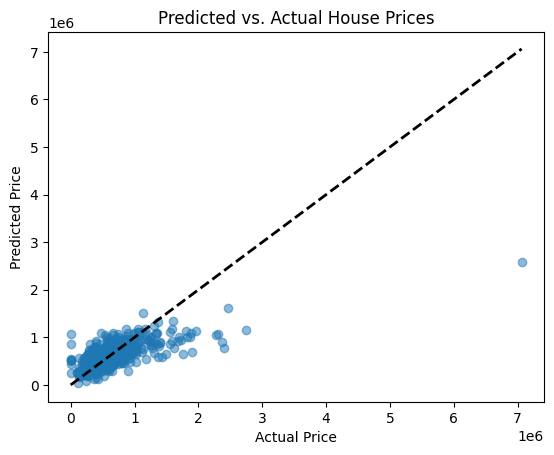

In [16]:
preds = model.predict([X_test_city, X_test_num])

plt.scatter(y_test, preds[0], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs. Actual House Prices')
plt.show()

In [58]:
rmse = np.sqrt(mean_squared_error(y_test, preds[0]))
r2 = r2_score(y_test, preds[0])
print(f"Test RMSE: {rmse:.2f}, R²: {r2:.2f}")

Test RMSE: 280900.86, R²: 0.50


# 4. Explainability
To ensure the model’s predictions are interpretable, SHAP (SHapley Additive exPlanations) is used:
- **SHAP Analysis**: This technique assigns each feature a contribution to the predicted price, visualized via waterfall and summary bar plots.
- **Importance**: Understanding feature impacts (e.g., `sqft_living` vs. `waterfront`) is crucial for trust and decision-making in real estate.
The analysis uses a kernel explainer with a small background dataset to approximate Shapley values, focusing on the first 100 test samples.

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3241/3241 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

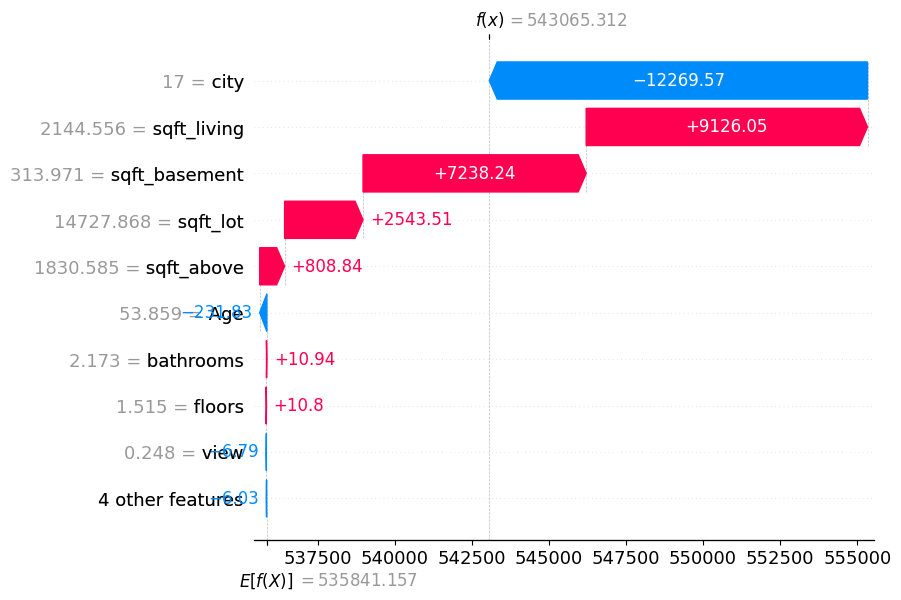

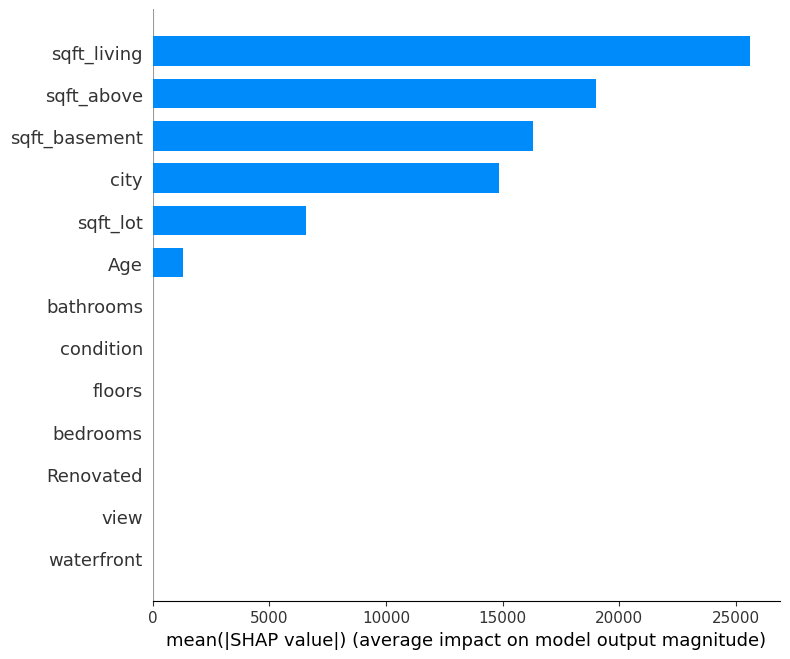

In [11]:
#9. SHAP EXPLANATIONS

preds = model.predict([X_test_city, X_test_num])

# Combine categorical and numerical for SHAP
X_train_city_2d = np.array(X_train_city).reshape(-1, 1)
X_test_city_2d = np.array(X_test_city).reshape(-1, 1)

# Drop low-variance columns
X_train_num_variance = X_train_num.var()
low_variance_cols = X_train_num_variance[X_train_num_variance < 1e-6].index
X_train_num = X_train_num.drop(columns=low_variance_cols)
X_test_num = X_test_num.drop(columns=low_variance_cols)

# Rebuild full datasets
X_train_full = pd.concat([pd.DataFrame(X_train_city_2d, columns=['city']), X_train_num], axis=1)
X_test_full = pd.concat([pd.DataFrame(X_test_city_2d, columns=['city']), X_test_num], axis=1)

# Impute missing values (same imputer as before)
imputer = SimpleImputer(strategy='mean')
X_train_full_imputed = imputer.fit_transform(X_train_full)
X_test_full_imputed = imputer.transform(X_test_full)

X_train_full = pd.DataFrame(X_train_full_imputed, columns=X_train_full.columns)
X_test_full = pd.DataFrame(X_test_full_imputed, columns=X_train_full.columns)

def predict_fn(data):
    city_data = data[:, 0].astype(int).reshape(-1, 1)
    num_data = data[:, 1:]
    predictions = model.predict([city_data, pd.DataFrame(num_data, columns=X_train_num.columns)])[0]
    return predictions.ravel()

background = X_train_full.iloc[:50, :].values

explainer = shap.KernelExplainer(predict_fn, background)

shap_values = explainer.shap_values(X_test_full.iloc[:100].values)

# Wrap shap_values with Explanation object
shap_explanation = shap.Explanation(values=shap_values,
                                  base_values=explainer.expected_value,
                                  data=X_test_full.iloc[:100].values,
                                  feature_names=X_test_full.columns)

# Use the Explanation object for the waterfall plot
shap.plots.waterfall(shap_explanation[0]) # Pass the first explanation from the list


shap.summary_plot(shap_values, X_test_full.iloc[:100], plot_type="bar", feature_names=X_train_full.columns)

# 5. Baseline Comparison
A linear regression model is implemented as a baseline to assess the neural network’s added value:
- **Approach**: The baseline uses the same preprocessed features and imputes missing values with means.
- **Metrics**: Evaluated with RMSE (Root Mean Squared Error) and R² (Coefficient of Determination).
- **Results**: The baseline RMSE of approximately 399,698 and R² of -0.01 indicate poor fit, suggesting the neural network may offer improvement with proper training.
This comparison highlights the need for a more complex model to capture non-linear relationships in the data.

In [67]:
#10. BASELINE


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Combine categorical and numerical for baseline model
X_train_city_2d = np.array(X_train_city).reshape(-1, 1)
X_train_full = pd.concat([pd.DataFrame(X_train_city_2d, columns=['city']), X_train_num], axis=1)

# Drop low-variance columns from X_train_full as well
# Ensure low_variance_cols is calculated based on the combined DataFrame
X_train_full_variance = X_train_full.var()
low_variance_cols = X_train_full_variance[X_train_full_variance < 1e-6].index
X_train_full = X_train_full.drop(columns=low_variance_cols, errors='ignore')

columns = X_train_full.columns
# Create X_test_full with the same columns as X_train_full
X_test_city_2d = np.array(X_test_city).reshape(-1, 1)
X_test_full = pd.concat([pd.DataFrame(X_test_city_2d, columns=['city']), X_test_num], axis=1)

# Ensure X_test_full has the same columns and is filtered for low variance similarly to X_train_full
X_test_full = X_test_full[X_train_full.columns]  # Ensure same columns as X_train_full
X_test_full = X_test_full.drop(columns=low_variance_cols, errors='ignore') # Drop low variance columns

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
X_train_full = imputer.fit_transform(X_train_full) # Fit and transform on training data
X_test_full = imputer.transform(X_test_full) # Transform test data

X_train_full = pd.DataFrame(X_train_full, columns=columns)
X_test_full = pd.DataFrame(X_test_full, columns=columns)

# Before fitting, ensure X_train_full and y_train have the same number of samples
# This is likely where the issue is; adjust X_train_full or y_train to match lengths
X_train_full = X_train_full.iloc[:len(y_train)] # Adjust X_train_full to match y_train length
# Alternatively, you might need to adjust y_train:
# y_train = y_train.iloc[:len(X_train_full)]

baseline_model = LinearRegression()
baseline_model.fit(X_train_full, y_train)

baseline_preds = baseline_model.predict(X_test_full)

# Ensure y_test and baseline_preds have the same length before calculating RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds[:len(y_test)])) # Slice baseline_preds to match y_test length
baseline_r2 = r2_score(y_test, baseline_preds[:len(y_test)]) # Slice baseline_preds to match y_test length

print(f"Baseline Model - RMSE: {baseline_rmse:.2f}, R²: {baseline_r2:.2f}")

Baseline Model - RMSE: 399698.93, R²: -0.01
